In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from src.names import *
from src.visual import *
from src.dumping_loading import *

plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
np.random.seed(seed=42)

from typing import Optional, Union

import numpy as np
import pandas as pd

import seaborn as sns # for better visual aesthetics
sns.set_theme(style='white', context='paper')
%config InlineBackend.figure_format = "svg"

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

from polara import get_movielens_data
from src.splits import *
from src.utils import *
from src.algorithms import *
from src.visual import *
from src.testing import *
from src.names import *

import datetime
import dateutil.relativedelta

# Data prep

In [18]:
data_, genres_info = get_movielens_data(
    get_genres=True, # get genre information in addition to ratings
    split_genres=False,
    include_time=True
)
data_['timestamp'] = pd.to_datetime(data_['timestamp'], unit='s')
data_ = data_.sort_values('timestamp')

data_.reset_index(inplace=True, drop=True)
data = delete_low_and_binarize(data_)
print(data.shape)
data.head()

(575281, 4)


,userid,movieid,rating,timestamp
0,6040,858,1,2000-04-25 23:05:32
1,6040,2384,1,2000-04-25 23:05:54
2,6040,593,1,2000-04-25 23:05:54
3,6040,1961,1,2000-04-25 23:06:17
4,6040,2019,1,2000-04-25 23:06:17


In [ ]:
split_type = 3

# checkpoint = max(data['timestamp']) - dateutil.relativedelta.relativedelta(months=8)
# training_, holdout_ = data[data['timestamp'] < checkpoint], data[data['timestamp'] >= checkpoint]
checkpoint = int(len(data) * 0.8)
training_, holdout_ = data[:checkpoint], data[checkpoint:]
print(f"training_.shape: {training_.shape}")
print(f"holdout_.shape: {holdout_.shape}")
print(f"train %: {(training_.shape[0]/data.shape[0]) * 100}%")

print(checkpoint)

# чистим данные под вид сплита
training, holdout = configure_split_type(training_, holdout_, type=split_type)
assert training_.shape == training.shape
clean_data = pd.concat([training, holdout])

# делаем сквозные возрастающие айди для пользователей
global_mapping_userid = update_mapping(clean_data, 'userid')
apply_mapping(clean_data, global_mapping_userid, 'userid')

# делаем сквозные возрастающие айди для айтемов
global_mapping_movieid = update_mapping(clean_data, 'movieid')
apply_mapping(clean_data, global_mapping_movieid, 'movieid')

# обратно делим на трейн и тест
split_idx = training.shape[0]
training, holdout = clean_data[:split_idx], clean_data[split_idx:]
assert training_.shape == training.shape

In [ ]:
data = prepare_split(
    training=training, 
    holdout=holdout, 
    n_periods=5, 
    flag_virtual=True, 
    periods_split_type=INTERACTION_SPLIT, 
    n_active_users_in_period=None
)

In [21]:
import pickle

# data_fname = '8periods-8month-0-virtual-interactions'
# with open(f'positive_data/{data_fname}', 'rb') as f:
#     data = pickle.load(f)

# data_fname = '8periods-0-nonvirtual-interactions'
# import pickle
# with open(f'positive_data/{data_fname}', 'wb') as f:
#     pickle.dump(data, f)

# Basic

In [22]:
rank = 50
K = 10
periods_split_type = INTERACTION_SPLIT
flag_virtual = True
users_first = True

In [23]:
metrics_dict = {}
for alg_name in ALL_ALG_NAMES[:2]:
    metrics = metrics_experiment(
        algorithm_name=alg_name,
        rank=rank,
        K=K,
        pure_cold_first=False,
        users_first=True,
        update_bigger_first=True,
        training=training,
        data=data
    )
    metrics_dict[alg_name] = metrics

psi 1 order: 100%|██████████| 6/6 [00:27<00:00,  4.59s/it]


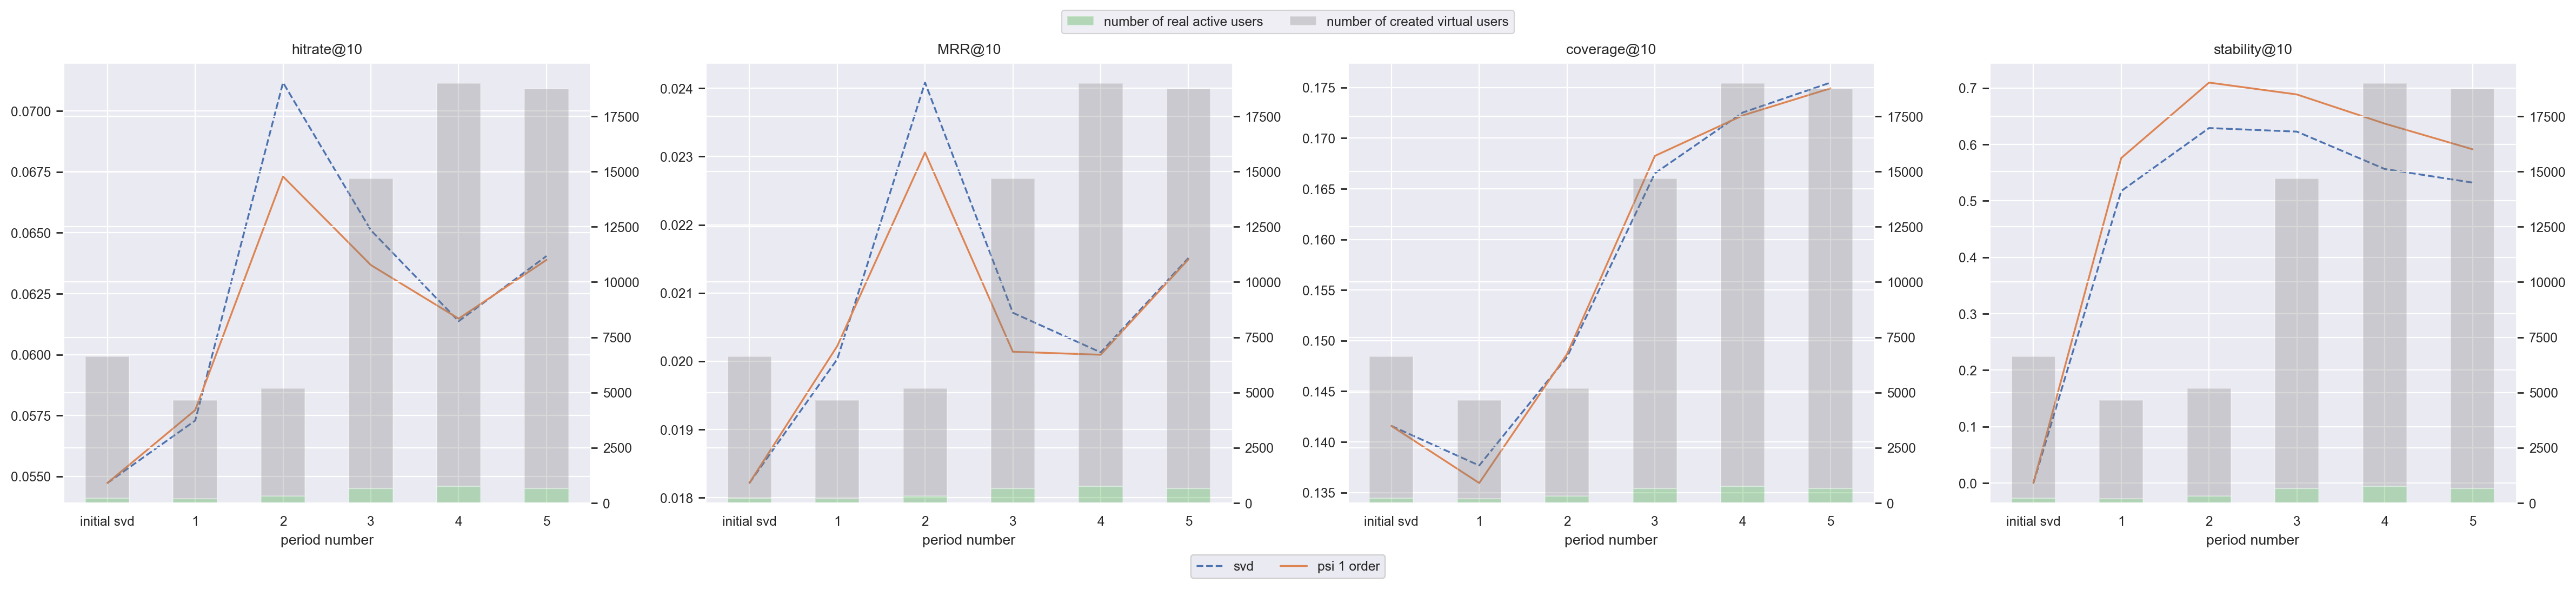

In [48]:
visualize_all(metrics_dict, K, data)

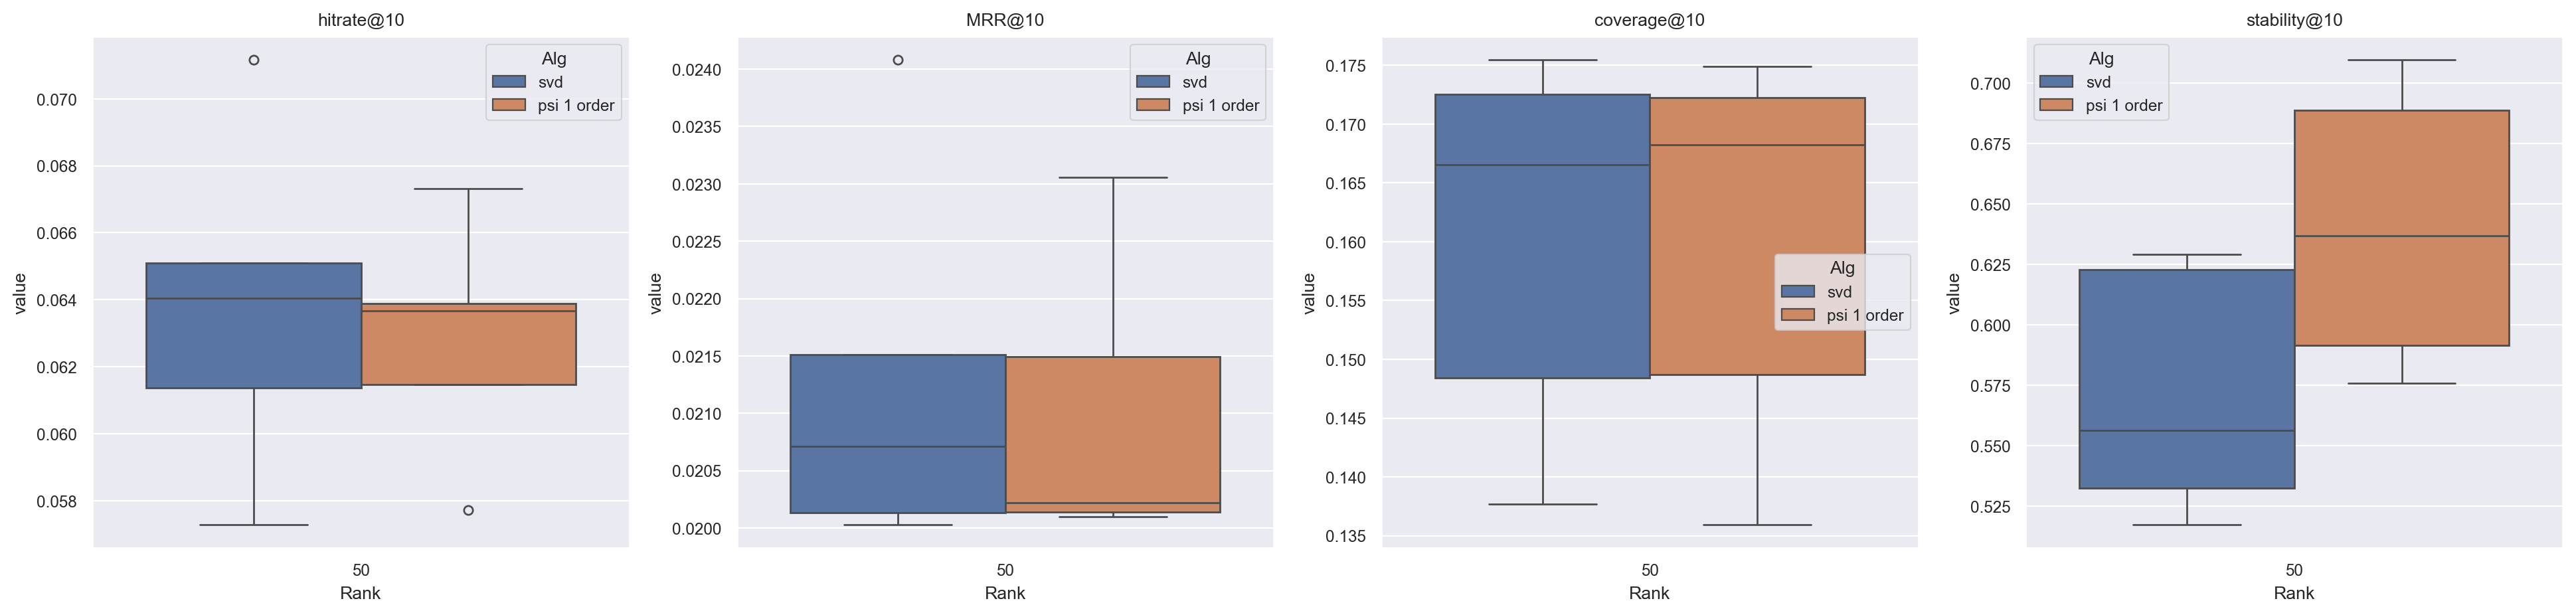

In [25]:
one_ranks_metrics = {}
one_ranks_metrics[SVD] = {50: metrics_dict[SVD]}
one_ranks_metrics[PSI1] = {50: metrics_dict[PSI1]}
visualize_boxplots(one_ranks_metrics)

# Ranks

In [26]:
total_users = len(training['userid'].unique())
total_movies = len(training['movieid'].unique())
train_matrix = get_matrix(training, total_users, total_movies)
K = 10

In [27]:
ranks = [10, 20, 50, 80]

all_ranks_metrics = {}
for alg_name in ALL_ALG_NAMES[:-2]:

    all_metrics = {}
    for rank in ranks:
        metrics = metrics_experiment(
            algorithm_name=alg_name,
            rank=rank,
            K=K,
            pure_cold_first=False,
            users_first=True,
            update_bigger_first=True,
            training=training,
            data=data
        )
        all_metrics[rank] = metrics

    all_ranks_metrics[alg_name] = all_metrics

reused projector (incremental): 100%|██████████| 6/6 [00:25<00:00,  4.21s/it]


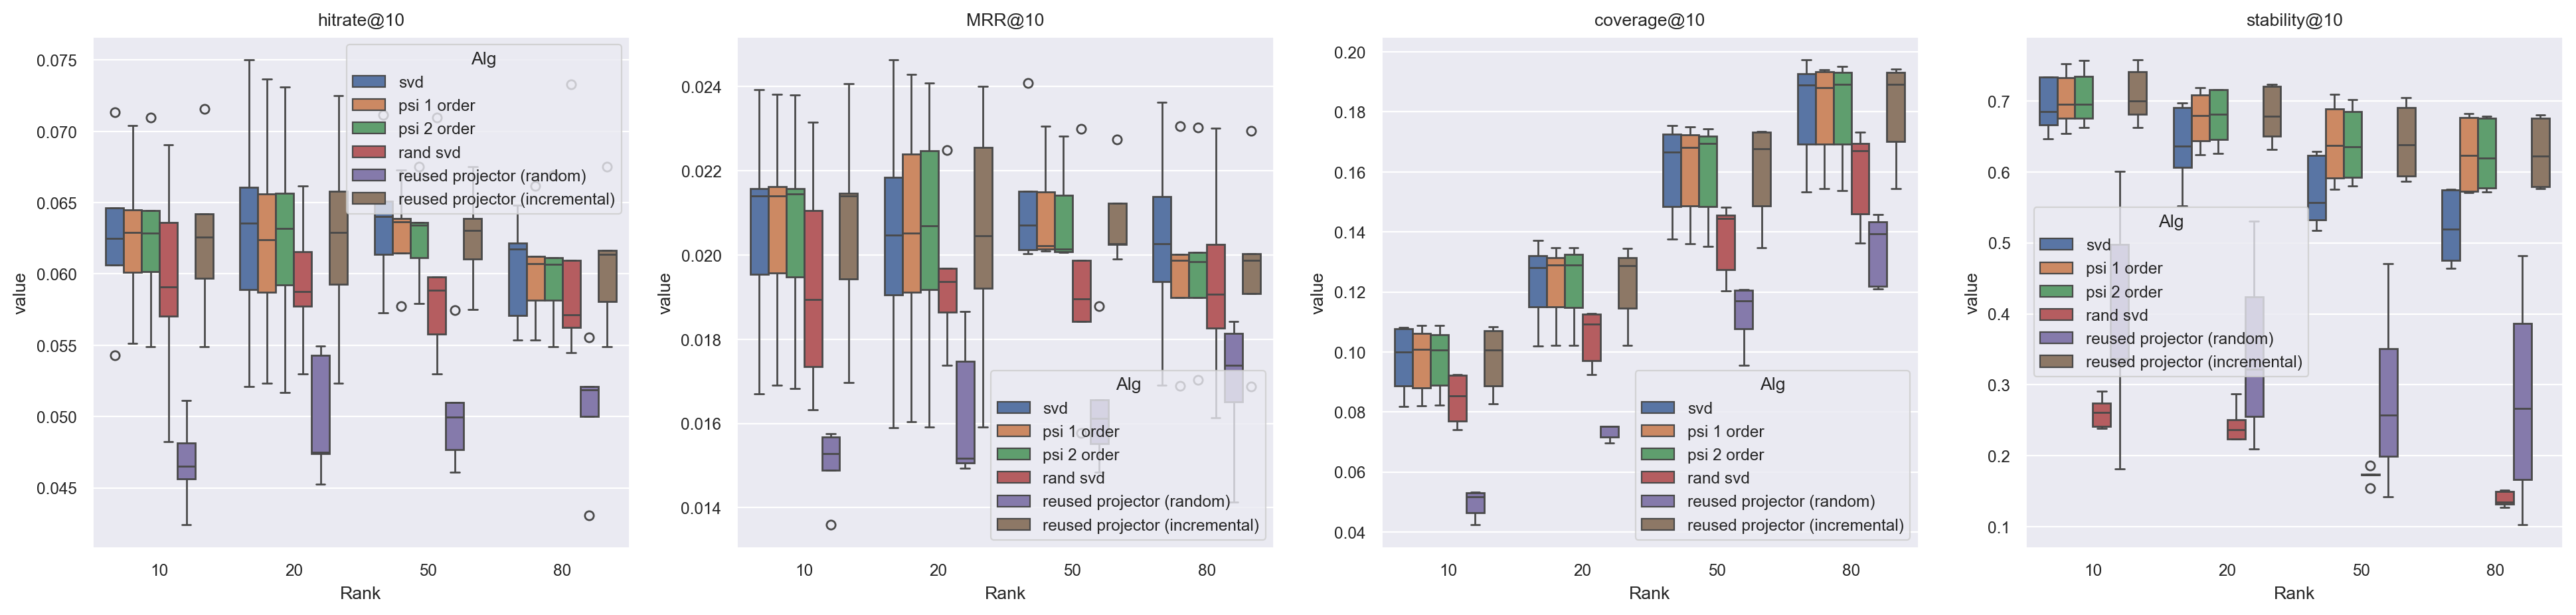

In [28]:
visualize_boxplots(all_ranks_metrics)

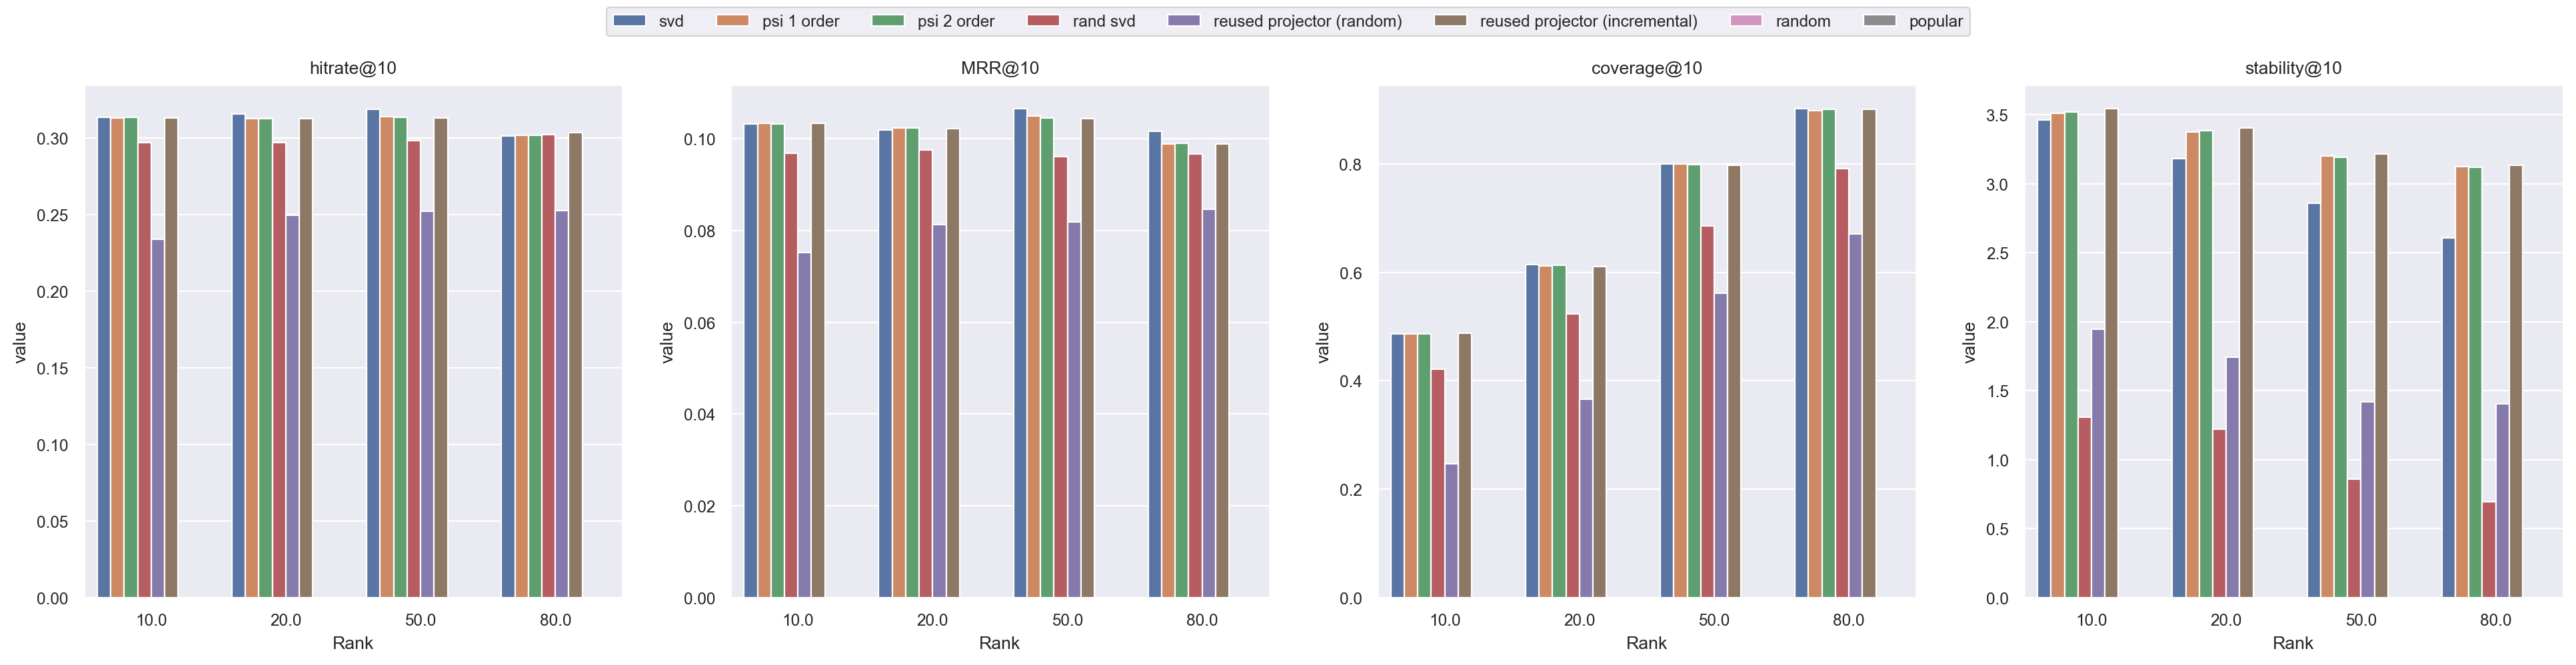

In [61]:
visualize_cummulative(all_ranks_metrics, K=10)